### Q1 Read in data

In [1]:
import pandas as pd
import numpy as np
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
df_gold = pd.read_csv('gold.txt', sep = "\s", header = None, names = ['url', 'category'], engine='python')
df_labels = pd.read_csv('labels.txt', sep = "\s", header = None, names = ['turk', 'url', 'category'], engine='python')

In [3]:
print(len(df_gold))
print(len(df_labels))

1517
92721


### Q2 Split into two DataFrames

In [4]:
uniquie_url_gold = list(df_gold['url'].unique())


In [5]:
labels_on_gold = df_labels.merge(df_gold, on = "url", suffixes = ['_labels', '_gold'])
len(labels_on_gold)

3324

In [6]:
#Alternate way of solving:
labels_unknown = df_labels[~df_labels['url'].isin(labels_on_gold['url'])]
len(labels_unknown)

89397

### Q3 Compute accuracies of turks

In [7]:
labels_on_gold['Correctness'] = np.where(labels_on_gold['category_labels'] == labels_on_gold['category_gold'], 1, 0)

rater_goodness = labels_on_gold.groupby('turk')['Correctness'].agg(['count', 'mean'])
rater_goodness.head()

,count,mean
turk,,
A112DVP1KG4QZU,1,1.000000
A1253FXHCZ9CWM,29,0.517241
A12CY1Q7XKJJDE,1,1.000000
A12RE8G66WTO8B,20,0.750000
A12Y1GTGIQDGRA,3,0.333333


### Q4 Odds ratios

In [8]:
rater_goodness['odds'] = rater_goodness['mean']/(1.001-rater_goodness['mean'])
rater_goodness.rename(columns ={'mean':'Average_Correctness'}, inplace=True)
rater_goodness.head()

,count,Average_Correctness,odds
turk,,,
A112DVP1KG4QZU,1,1.000000,1000.000000
A1253FXHCZ9CWM,29,0.517241,1.069214
A12CY1Q7XKJJDE,1,1.000000,1000.000000
A12RE8G66WTO8B,20,0.750000,2.988048
A12Y1GTGIQDGRA,3,0.333333,0.499251


### Q5 Most accurate turks

In [9]:
df_accurateness_20 = rater_goodness[rater_goodness['count'] >= 20]
df_accurateness_20_10 = df_accurateness_20.sort_values('Average_Correctness', ascending = False)[:10]
df_accurateness_20_10.head(10)

,count,Average_Correctness,odds
turk,,,
A2U0R4X38GUKZE,20,0.950000,18.627451
A22C0PJUBFJTI0,36,0.916667,10.869565
A23YQUBXZPKILZ,24,0.875000,6.944444
ATVALOQVDCMZW,103,0.854369,5.826657
A1HIXWH4OXT8S4,40,0.825000,4.687500
A3220HG1O83HQ4,22,0.818182,4.475385
A32W20KGQXS0LL,25,0.800000,3.980100
A20PWAB7G3HDHU,20,0.800000,3.980100
AJSJVK40F5HM6,28,0.785714,3.649635


In [10]:
df_accurateness_20_10.index.values

array(['A2U0R4X38GUKZE', 'A22C0PJUBFJTI0', 'A23YQUBXZPKILZ',
       'ATVALOQVDCMZW', 'A1HIXWH4OXT8S4', 'A3220HG1O83HQ4',
       'A32W20KGQXS0LL', 'A20PWAB7G3HDHU', 'AJSJVK40F5HM6',
       'A31OCN4MNHUQ6W'], dtype=object)

### Q6 Rating counts versus accuracy

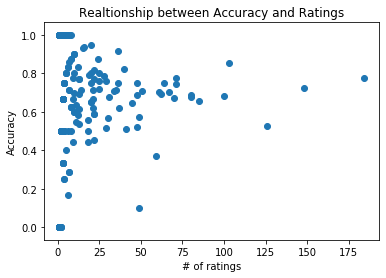

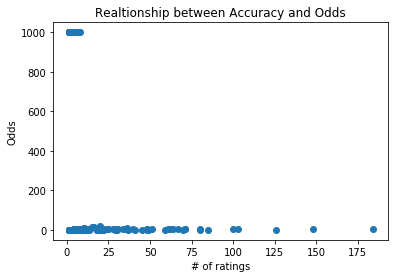

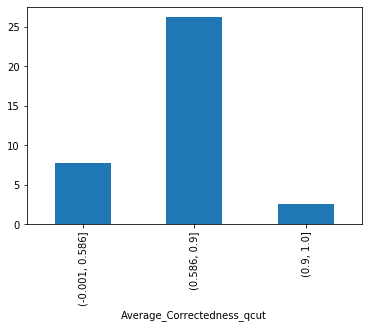

In [11]:
scatter(rater_goodness['count'],rater_goodness['Average_Correctness'])
xlabel('# of ratings')
ylabel('Accuracy')
title('Realtionship between Accuracy and Ratings')
show()

scatter(rater_goodness['count'],rater_goodness['odds'])
xlabel('# of ratings')
ylabel('Odds')
title('Realtionship between Accuracy and Odds')
show()

rater_goodness['Average_Correctedness_qcut'] = pd.qcut(rater_goodness['Average_Correctness'], q=3)
rater_goodness.groupby('Average_Correctedness_qcut')['count'].mean().plot(kind = 'bar')

Turks with high accuracy are labeling URLs less than mean value and turks with medium accuracy(between 0.5 and 0.9) are doing more than typical labeling.

### Q7 Overall predicted odds

In [12]:
quantile_75 = rater_goodness.quantile(0.75)['count']

In [13]:
list_75 = rater_goodness[rater_goodness['count'] > quantile_75].reset_index()
labels_unknown_reliable_75 = labels_unknown.merge(list_75[['turk','odds']],on='turk')

In [14]:
reliable_odds_75 = labels_unknown_reliable_75.groupby(['url','category'])[['odds']].agg('prod')
reliable_odds_75.head()

odds
url                         category           
http://0-101.net            G          2.155963
http://000.cc               G          1.460583
http://0000.jp              G         14.488244
http://000relationships.com G          5.681060
                            P          1.851852

### Q8 Predicted categories

In [15]:
reset_75 = reliable_odds_75.reset_index()
sort_reliable_75 = reset_75.groupby(['url'])['odds'].max().to_frame(name='top odds')
merge_75 = sort_reliable_75.merge(reset_75, left_on = ['url', 'top odds'], right_on =['url', 'odds'])
result_75 = merge_75[['url', 'category', 'top odds']]
result_75 = result_75.rename(columns = {'category':'top category'}).set_index('url')
result_75.head()

,top category,top odds
url,,
http://0-101.net,G,2.155963
http://000.cc,G,1.460583
http://0000.jp,G,14.488244
http://000relationships.com,G,5.681060
http://000vitamins.com,G,3.784982


### Q9 Predicted categories using more turks

In [16]:
quantile_25 = rater_goodness.quantile(0.25)['count']
list_25 = rater_goodness[rater_goodness['count'] > quantile_25].reset_index()

labels_unknown_reliable_25 = labels_unknown.merge(list_25[['turk','odds']],on='turk')
reliable_odds_25 = labels_unknown_reliable_25.groupby(['url','category'])[['odds']].agg('prod')
sort_reliable_25 = reliable_odds_25.reset_index().sort_values(by =['url','odds'],ascending= False)
result_25 = sort_reliable_25.groupby('url').first()

merge_75_25 = result_75.merge(result_25, on = "url", suffixes = ['_75','_25']).reset_index()

In [17]:
crosstab = pd.crosstab(merge_75_25['top category'],merge_75_25['category'])
crosstab

category,G,P,R,X
top category,,,,
G,8327,574,186,216
P,190,329,47,19
R,21,34,128,25
X,27,6,26,457


The maximum number of errors have occured for P category (top 25%) and it has been misclassified as G (top 75%)